In [19]:
import os
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
import sys
if not os.path.exists("Pointnet_Pointnet2_pytorch"):
    !git clone https://github.com/yanx27/Pointnet_Pointnet2_pytorch.git Pointnet_Pointnet2_pytorch
repo_path = "./Pointnet_Pointnet2_pytorch"  
sys.path.append(os.path.abspath(repo_path))
sys.path.append(os.path.abspath(os.path.join(repo_path, "models")))


In [3]:
objects_path = os.path.join('.', 'sydney-urban-objects-dataset/sydney-urban-objects-dataset', 'objects')

print("Objects path is:", objects_path)
print("Contents of 'objects':", os.listdir(objects_path))


Objects path is: .\sydney-urban-objects-dataset/sydney-urban-objects-dataset\objects
Contents of 'objects': ['4wd.0.2299.bin', '4wd.0.2299.bin.meta', '4wd.0.2299.csv', '4wd.1.2446.bin', '4wd.1.2446.bin.meta', '4wd.1.2446.csv', '4wd.10.17589.bin', '4wd.10.17589.bin.meta', '4wd.10.17589.csv', '4wd.11.6994.bin', '4wd.11.6994.bin.meta', '4wd.11.6994.csv', '4wd.12.3582.bin', '4wd.12.3582.bin.meta', '4wd.12.3582.csv', '4wd.13.270.bin', '4wd.13.270.bin.meta', '4wd.13.270.csv', '4wd.14.5229.bin', '4wd.14.5229.bin.meta', '4wd.14.5229.csv', '4wd.15.5563.bin', '4wd.15.5563.bin.meta', '4wd.15.5563.csv', '4wd.16.6123.bin', '4wd.16.6123.bin.meta', '4wd.16.6123.csv', '4wd.17.6783.bin', '4wd.17.6783.bin.meta', '4wd.17.6783.csv', '4wd.18.7288.bin', '4wd.18.7288.bin.meta', '4wd.18.7288.csv', '4wd.19.10974.bin', '4wd.19.10974.bin.meta', '4wd.19.10974.csv', '4wd.2.3582.bin', '4wd.2.3582.bin.meta', '4wd.2.3582.csv', '4wd.20.12346.bin', '4wd.20.12346.bin.meta', '4wd.20.12346.csv', '4wd.3.4043.bin', '4wd.3.4

In [4]:
labels_dict = {
    '4wd': 0,
    'bench': 1,
    'bicycle': 2,
    'biker': 3,
    'building': 4,
    'bus': 5,
    'car': 6,
    'cyclist': 7,
    'excavator': 8,
    'pedestrian': 9,
    'pillar': 10,
    'pole': 11,
    'post': 12,
    'scooter': 13,
    'ticket_machine': 14,
    'traffic_lights': 15,
    'traffic_sign': 16,
    'trailer': 17,
    'trash': 18,
    'tree': 19,
    'truck': 20,
    'trunk': 21,
    'umbrella': 22,
    'ute': 23,
    'van': 24,
    'vegetation': 25
}

num_classes = len(labels_dict)

In [5]:
def read_bin(file_name):
    names   = ['t','intensity','id','x','y','z','azimuth','range','pid']
    formats = ['int64','uint8','uint8',
               'float32','float32','float32',
               'float32','float32','int32']

    binType = np.dtype(dict(names=names, formats=formats))
    data = np.fromfile(file_name, binType)

    # 3D points, one per row:
    P = np.vstack((data['x'], data['y'], data['z'])).T
    return P


In [6]:
def sub_sample(pcs, labels, k):
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis=1)
    chosen = random.choices(res1, k=k)  
    chosen = np.asarray(chosen)
    
    pcs_out = chosen[:, :-1]
    labels_out = chosen[:, -1]
    return pcs_out, labels_out

In [7]:
def farthest_point_sample(points, n_samples):
    """
    points: numpy array of shape (N, 3)
    n_samples: number of points to sample
    returns: indices of the selected points of shape (n_samples,)
    """
    N, _ = points.shape
    if n_samples >= N:
        extra = np.random.choice(N, n_samples - N, replace=True)
        return np.concatenate([np.arange(N), extra])
    
    centroids = np.zeros((n_samples,), dtype=np.int64)
    distances = np.full((N,), np.inf)
    farthest = np.random.randint(0, N)
    
    for i in range(n_samples):
        centroids[i] = farthest
        centroid = points[farthest, :]  # shape (3,)
        dist = np.sum((points - centroid) ** 2, axis=1)
        distances = np.minimum(distances, dist)
        farthest = np.argmax(distances)
    return centroids

In [8]:
class SydneyUrban(Dataset):
    def __init__(self, file_paths, labels, num_points=2048, transform=False):
        self.files = file_paths
        self.labels = labels
        self.num_points = num_points
        self.transform = transform

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        pts = read_bin(self.files[idx])
        label = self.labels[idx]
        
        # Apply data augmentation if enabled using 'pts'
        if self.transform:
            pts = self.random_rotation_z(pts)
            pts = self.random_scaling(pts)
            pts = self.random_jitter(pts)
        
        # Use farthest point sampling on the xyz coordinates
        if pts.shape[0] > self.num_points:
            fps_idxs = farthest_point_sample(pts[:, :3], self.num_points)
            points = pts[fps_idxs]
        else:
            idxs = np.random.choice(pts.shape[0], self.num_points, replace=True)
            points = pts[idxs]
        
        # Normalize the points (only x,y,z coordinates)
        points[:, :3] = self.normalize(points[:, :3])
        
        points = torch.from_numpy(points).float()
        label = torch.tensor(label).long()
        
        return points, label
        
    def normalize(self, points):
        centroid = np.mean(points, axis=0)
        points -= centroid
        furthest_distance = np.max(np.sqrt(np.sum(points ** 2, axis=1)))
        points /= furthest_distance
        return points
    
    def random_rotation_z(self, pts):
        theta = np.random.uniform(0, 2 * np.pi)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [0,              0,             1]
        ], dtype=np.float32)
        pts[:, :3] = pts[:, :3].dot(rotation_matrix)
        return pts
    
    def random_scaling(self, pts, scale_low=0.9, scale_high=1.1):
        scale = np.random.uniform(scale_low, scale_high)
        pts[:, :3] *= scale
        return pts
    
    def random_jitter(self, pts, sigma=0.01, clip=0.05):
        jitter = np.clip(sigma * np.random.randn(pts.shape[0], 3), -clip, clip)
        pts[:, :3] += jitter
        return pts

In [9]:
all_files = [
    os.path.join(objects_path,f)
    for f in os.listdir(objects_path)
    if f.endswith('.bin') and not f.endswith('.bin.meta')
    ]

all_labels = []
for f in all_files:
    file_name = os.path.basename(f)
    label_str = file_name.split('.')[0]
    num_label = labels_dict[label_str]
    all_labels.append(num_label)

In [10]:
len(all_files), len(all_labels)

(631, 631)

In [11]:
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42) 

In [12]:
train_dataset = SydneyUrban(train_files, train_labels, num_points=2048, transform=True)
test_dataset = SydneyUrban(test_files, test_labels, num_points=2048, transform=False)

In [13]:
len(train_dataset), len(test_dataset)

(504, 127)

#### Visualize the dataset

In [14]:
reverse_labels = {v: k for k, v in labels_dict.items()}

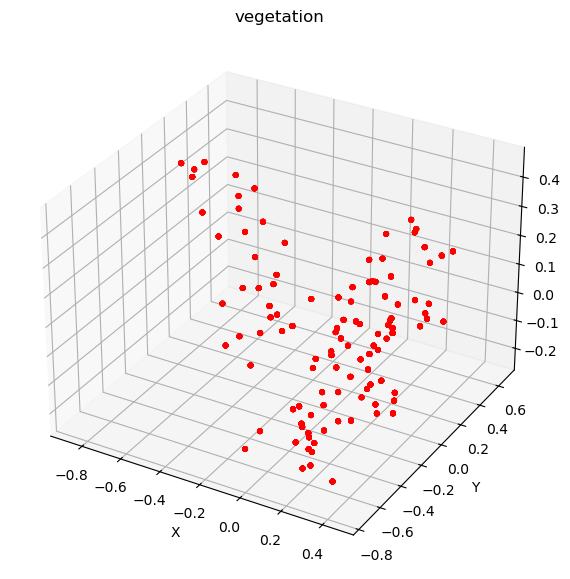

Class: vegetation


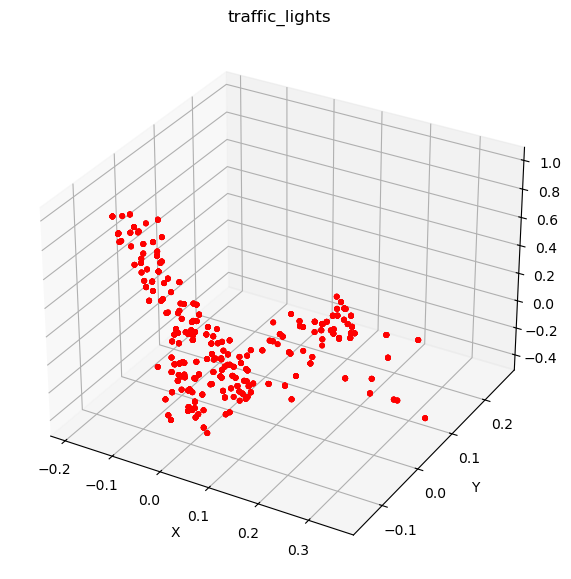

Class: traffic_lights


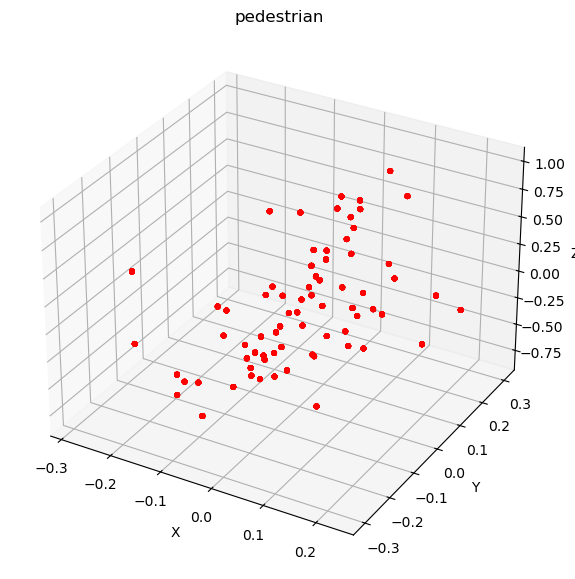

Class: pedestrian


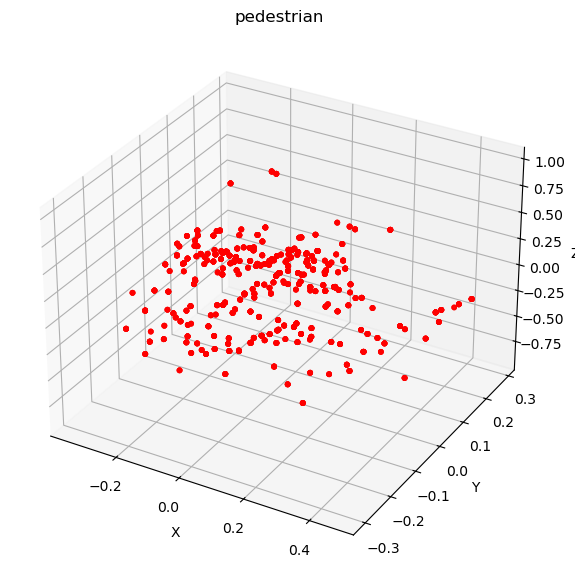

Class: pedestrian


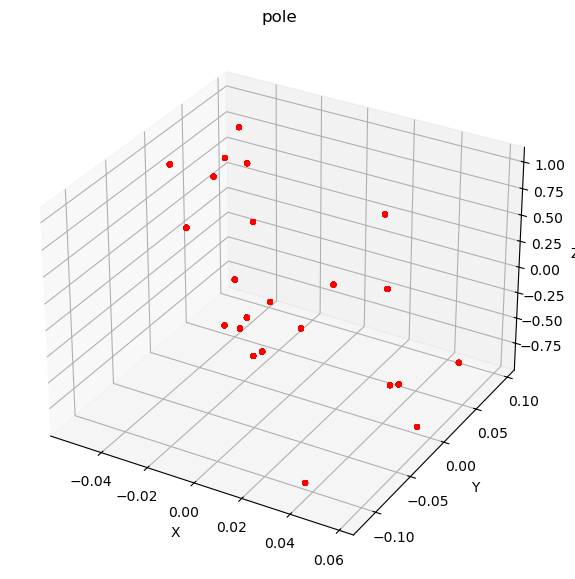

Class: pole


In [15]:
def plot_pc(points, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o', s=10, alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    
# visualize 5 samples
for i in range(5):
    idx = np.random.randint(0, len(train_dataset))
    sample = train_dataset[idx]
    points = sample[0].numpy()
    label = sample[1].item()
    class_name = reverse_labels[label]
    
    plot_pc(points, class_name)
    print(f"Class: {class_name}")
    

In [16]:
from models.pointnet2_cls_ssg import get_model
model = get_model(num_class=num_classes, normal_channel=False)  
model = model.cuda()
model

get_model(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(131, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNetSetAbstract

In [17]:
def train(model, train_dataset, test_dataset, device, epochs=100, batch_size=32, lr=0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for pc_batch, label_batch in train_loader:
            pc_batch = pc_batch.permute(0, 2, 1)
            pc_batch = pc_batch.cuda()
            label_batch = label_batch.cuda()
            
            optimizer.zero_grad()
            logits,_ = model(pc_batch)
            loss = criterion(logits, label_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * pc_batch.size(0)
            
            _, predicted = torch.max(logits, 1)
            correct_train += (predicted == label_batch).sum().item()
            total_train += label_batch.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset) 
        epoch_train_acc = correct_train / total_train
        
        
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for pc_batch, label_batch in test_loader:
                pc_batch = pc_batch.permute(0, 2, 1)
                pc_batch = pc_batch.cuda()
                label_batch = label_batch.cuda()
                
                logits,_ = model(pc_batch)
                test_loss = criterion(logits, label_batch)
                running_test_loss += test_loss.item() * pc_batch.size(0)
                
                _, predicted = torch.max(logits, 1)
                total_test += label_batch.size(0)
                correct_test += (predicted == label_batch).sum().item()
                
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        epoch_test_acc = correct_test / total_test
        
        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)
        train_accuracies.append(epoch_train_acc)
        test_accuracies.append(epoch_test_acc)

        print(f"Epoch {epoch+1}/{100} | "
            f"Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | "
            f"Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_test_acc:.4f}")
        
    epochs_axis = np.arange(1, epochs + 1)
    
    plt.figure()
    plt.plot(epochs_axis, train_losses, label='Train Loss')
    plt.plot(epochs_axis, test_losses, label='Test Loss')
    plt.legend()
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    plt.figure()
    plt.plot(epochs_axis, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_axis, test_accuracies, label='Test Accuracy')
    plt.legend()
    plt.title("Training and Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
    
    return train_losses, test_losses, train_accuracies, test_accuracies
        

==========Running with seed: 42==========
Epoch 1/100 | Train Loss: 2.6084 | Test Loss: 4.5215 | Train Acc: 0.3254 | Test Acc: 0.0315
Epoch 2/100 | Train Loss: 1.8169 | Test Loss: 4.3336 | Train Acc: 0.4861 | Test Acc: 0.0315
Epoch 3/100 | Train Loss: 1.6189 | Test Loss: 3.5230 | Train Acc: 0.5298 | Test Acc: 0.0472
Epoch 4/100 | Train Loss: 1.4601 | Test Loss: 2.1250 | Train Acc: 0.5893 | Test Acc: 0.4094
Epoch 5/100 | Train Loss: 1.3492 | Test Loss: 1.2142 | Train Acc: 0.6032 | Test Acc: 0.6457
Epoch 6/100 | Train Loss: 1.2114 | Test Loss: 1.1706 | Train Acc: 0.6329 | Test Acc: 0.6378
Epoch 7/100 | Train Loss: 1.2063 | Test Loss: 1.1061 | Train Acc: 0.6429 | Test Acc: 0.6929
Epoch 8/100 | Train Loss: 1.1674 | Test Loss: 1.0564 | Train Acc: 0.6369 | Test Acc: 0.6850
Epoch 9/100 | Train Loss: 1.0874 | Test Loss: 1.2344 | Train Acc: 0.6746 | Test Acc: 0.6063
Epoch 10/100 | Train Loss: 1.0236 | Test Loss: 0.9710 | Train Acc: 0.6865 | Test Acc: 0.6772
Epoch 11/100 | Train Loss: 0.9485 | T

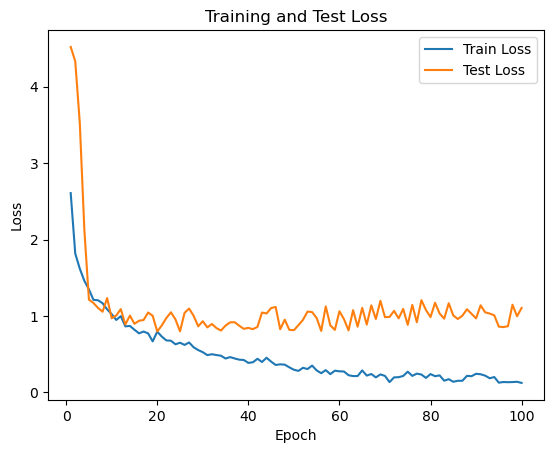

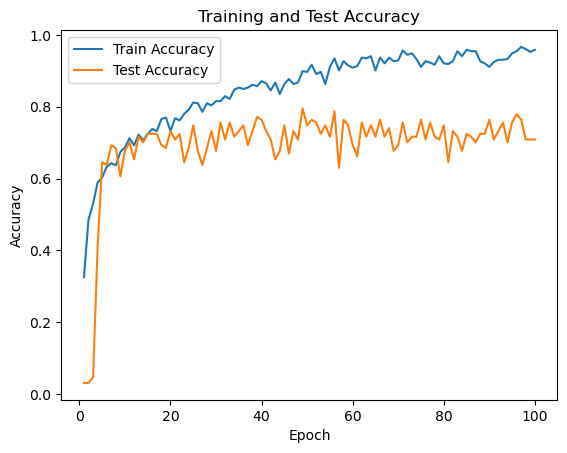

==========Running with seed: 123==========
Epoch 1/100 | Train Loss: 2.5970 | Test Loss: 3.9584 | Train Acc: 0.2996 | Test Acc: 0.0315
Epoch 2/100 | Train Loss: 1.8602 | Test Loss: 3.6053 | Train Acc: 0.4702 | Test Acc: 0.0315
Epoch 3/100 | Train Loss: 1.5848 | Test Loss: 3.5410 | Train Acc: 0.5417 | Test Acc: 0.0472
Epoch 4/100 | Train Loss: 1.4219 | Test Loss: 2.3534 | Train Acc: 0.5774 | Test Acc: 0.3701
Epoch 5/100 | Train Loss: 1.2415 | Test Loss: 1.1838 | Train Acc: 0.6190 | Test Acc: 0.6693
Epoch 6/100 | Train Loss: 1.2272 | Test Loss: 1.3464 | Train Acc: 0.6290 | Test Acc: 0.5827
Epoch 7/100 | Train Loss: 1.1683 | Test Loss: 1.1224 | Train Acc: 0.6548 | Test Acc: 0.6929
Epoch 8/100 | Train Loss: 1.1070 | Test Loss: 1.0889 | Train Acc: 0.6508 | Test Acc: 0.7008
Epoch 9/100 | Train Loss: 1.0714 | Test Loss: 1.0555 | Train Acc: 0.6667 | Test Acc: 0.6535
Epoch 10/100 | Train Loss: 1.0236 | Test Loss: 1.0479 | Train Acc: 0.6687 | Test Acc: 0.7087
Epoch 11/100 | Train Loss: 0.9613 | 

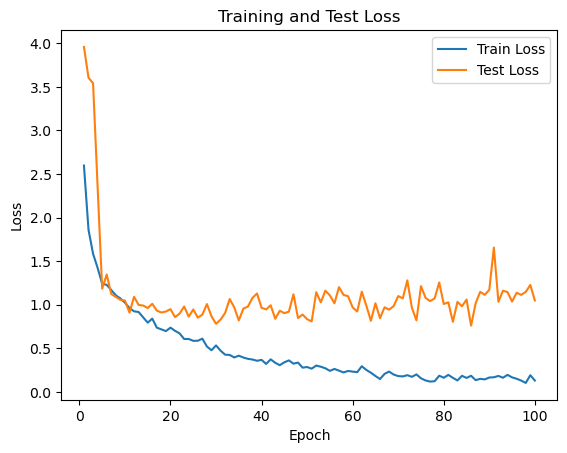

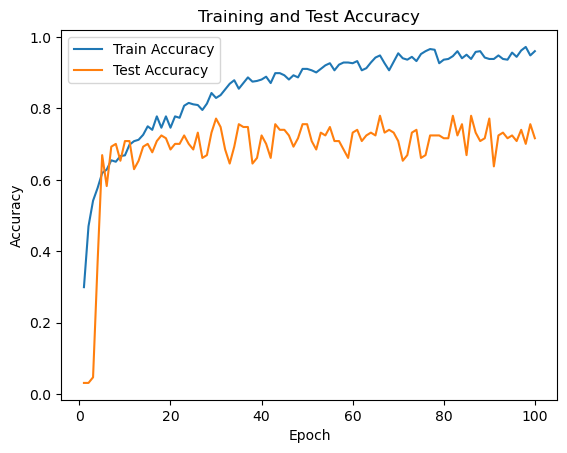

==========Running with seed: 456==========
Epoch 1/100 | Train Loss: 2.6178 | Test Loss: 4.1129 | Train Acc: 0.2996 | Test Acc: 0.0315
Epoch 2/100 | Train Loss: 1.8820 | Test Loss: 4.1080 | Train Acc: 0.4742 | Test Acc: 0.0472
Epoch 3/100 | Train Loss: 1.6105 | Test Loss: 3.3735 | Train Acc: 0.5298 | Test Acc: 0.0472
Epoch 4/100 | Train Loss: 1.4595 | Test Loss: 2.3369 | Train Acc: 0.5813 | Test Acc: 0.3071
Epoch 5/100 | Train Loss: 1.3402 | Test Loss: 1.3729 | Train Acc: 0.5952 | Test Acc: 0.6299
Epoch 6/100 | Train Loss: 1.2398 | Test Loss: 1.1853 | Train Acc: 0.6270 | Test Acc: 0.6142
Epoch 7/100 | Train Loss: 1.2073 | Test Loss: 1.0465 | Train Acc: 0.6270 | Test Acc: 0.6850
Epoch 8/100 | Train Loss: 1.0516 | Test Loss: 1.0778 | Train Acc: 0.6647 | Test Acc: 0.6850
Epoch 9/100 | Train Loss: 1.1493 | Test Loss: 1.1754 | Train Acc: 0.6369 | Test Acc: 0.6220
Epoch 10/100 | Train Loss: 1.0387 | Test Loss: 1.0052 | Train Acc: 0.6508 | Test Acc: 0.6850
Epoch 11/100 | Train Loss: 0.9940 | 

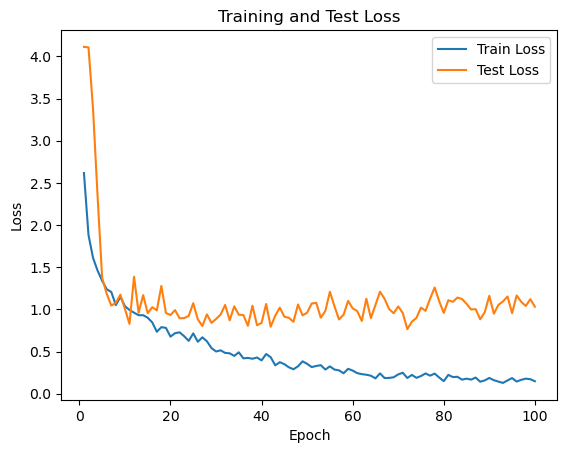

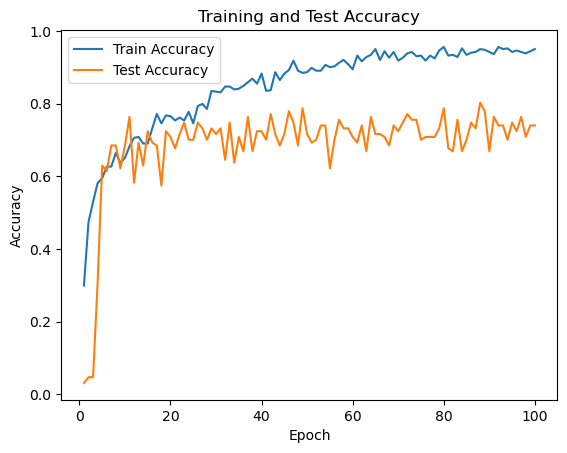

==========Running with seed: 789==========
Epoch 1/100 | Train Loss: 2.6568 | Test Loss: 4.3706 | Train Acc: 0.3135 | Test Acc: 0.0315
Epoch 2/100 | Train Loss: 1.9255 | Test Loss: 3.7241 | Train Acc: 0.4563 | Test Acc: 0.0315
Epoch 3/100 | Train Loss: 1.6228 | Test Loss: 3.0001 | Train Acc: 0.5278 | Test Acc: 0.0630
Epoch 4/100 | Train Loss: 1.4264 | Test Loss: 2.2880 | Train Acc: 0.5873 | Test Acc: 0.3071
Epoch 5/100 | Train Loss: 1.2995 | Test Loss: 1.2433 | Train Acc: 0.6151 | Test Acc: 0.6142
Epoch 6/100 | Train Loss: 1.2350 | Test Loss: 1.0168 | Train Acc: 0.6250 | Test Acc: 0.6850
Epoch 7/100 | Train Loss: 1.1665 | Test Loss: 1.0565 | Train Acc: 0.6409 | Test Acc: 0.6929
Epoch 8/100 | Train Loss: 1.1315 | Test Loss: 1.0464 | Train Acc: 0.6607 | Test Acc: 0.7008
Epoch 9/100 | Train Loss: 1.0802 | Test Loss: 1.0035 | Train Acc: 0.6786 | Test Acc: 0.7008
Epoch 10/100 | Train Loss: 0.9944 | Test Loss: 1.6326 | Train Acc: 0.6964 | Test Acc: 0.4803
Epoch 11/100 | Train Loss: 1.0245 | 

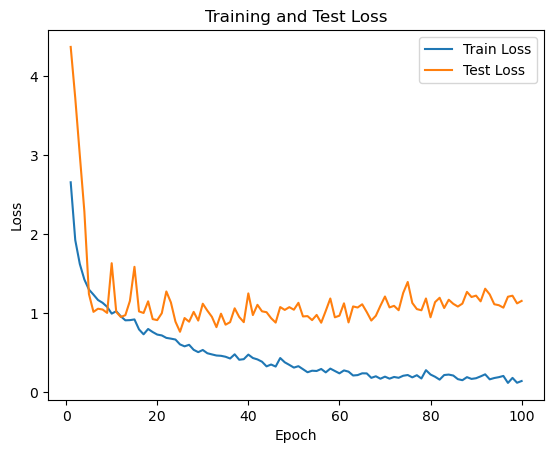

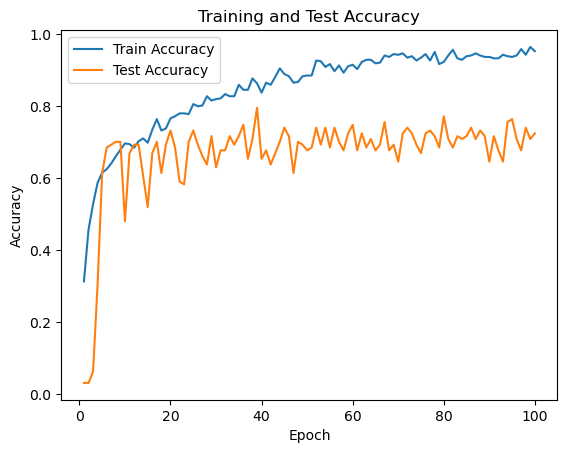

==========Running with seed: 101112==========
Epoch 1/100 | Train Loss: 2.5850 | Test Loss: 4.0481 | Train Acc: 0.3056 | Test Acc: 0.0315
Epoch 2/100 | Train Loss: 1.8420 | Test Loss: 3.9050 | Train Acc: 0.4762 | Test Acc: 0.0472
Epoch 3/100 | Train Loss: 1.5925 | Test Loss: 3.3772 | Train Acc: 0.5456 | Test Acc: 0.0472
Epoch 4/100 | Train Loss: 1.4147 | Test Loss: 2.3713 | Train Acc: 0.5635 | Test Acc: 0.4173
Epoch 5/100 | Train Loss: 1.2919 | Test Loss: 1.3109 | Train Acc: 0.6052 | Test Acc: 0.6220
Epoch 6/100 | Train Loss: 1.2363 | Test Loss: 1.2230 | Train Acc: 0.6210 | Test Acc: 0.6142
Epoch 7/100 | Train Loss: 1.1959 | Test Loss: 1.0483 | Train Acc: 0.6012 | Test Acc: 0.7008
Epoch 8/100 | Train Loss: 1.1127 | Test Loss: 1.1110 | Train Acc: 0.6548 | Test Acc: 0.6378
Epoch 9/100 | Train Loss: 1.0640 | Test Loss: 1.0030 | Train Acc: 0.6766 | Test Acc: 0.7165
Epoch 10/100 | Train Loss: 1.0556 | Test Loss: 1.0522 | Train Acc: 0.6587 | Test Acc: 0.6929
Epoch 11/100 | Train Loss: 0.9474

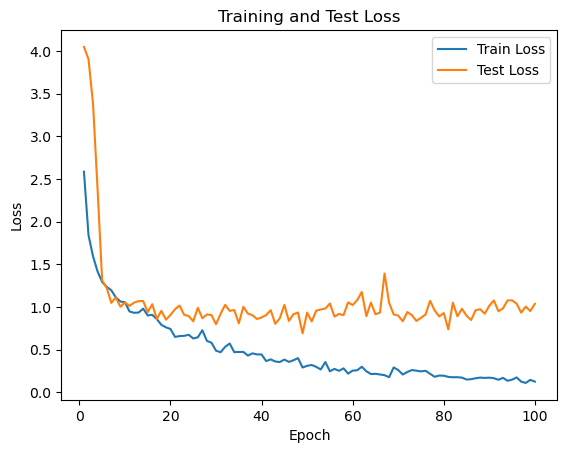

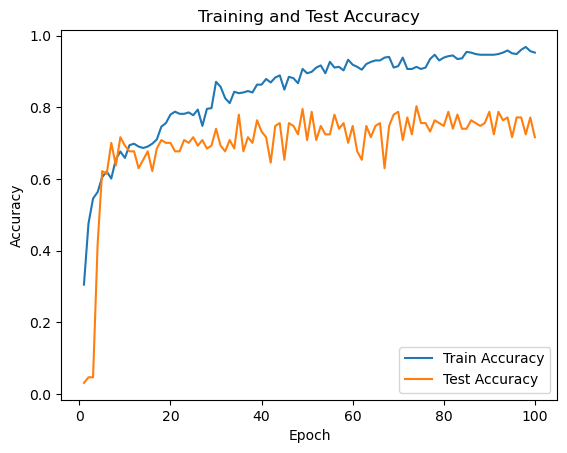

Mean Test Loss: 1.0757 ± 0.0476
Mean Test Accuracy: 0.7213 ± 0.0107


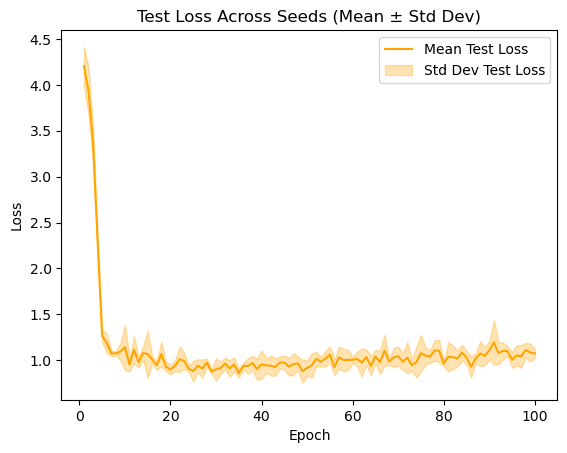

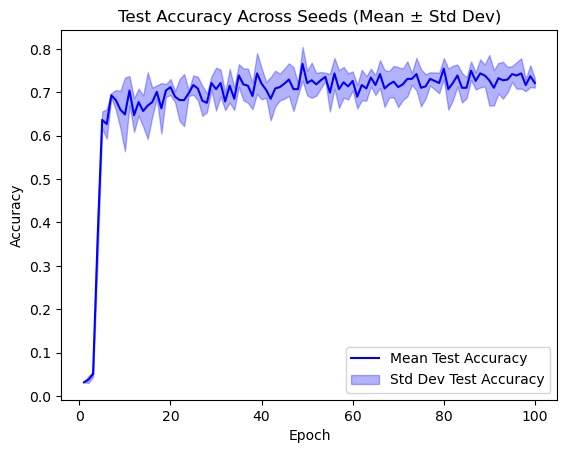

In [20]:
seeds = [42, 123, 456, 789, 101112]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100

all_test_losses = []
all_test_accuracies = []


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
for seed in seeds:
    print(f"==========Running with seed: {seed}==========")
    set_seed(seed)
    model = get_model(num_class=num_classes, normal_channel=False)  
    model = model.cuda()
    train_losses, test_losses, train_accuracies, test_accuracies = train(
        model, train_dataset, test_dataset, device, epochs=epochs, batch_size=32, lr=0.001
    )
    
    all_test_losses.append(test_losses)
    all_test_accuracies.append(test_accuracies)
    
all_test_losses = np.array(all_test_losses)
all_test_accuracies = np.array(all_test_accuracies)

final_test_losses = all_test_losses[:, -1]
final_test_accs   = all_test_accuracies[:, -1]

mean_test_loss = np.mean(final_test_losses)
std_test_loss  = np.std(final_test_losses)
mean_test_acc  = np.mean(final_test_accs)
std_test_acc   = np.std(final_test_accs)

print(f"Mean Test Loss: {mean_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Mean Test Accuracy: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

epochs_axis = np.arange(1, epochs + 1)
mean_loss_curves = np.mean(all_test_losses, axis=0)
std_loss_curves = np.std(all_test_losses, axis=0)
mean_acc_curves = np.mean(all_test_accuracies, axis=0)
std_acc_curves = np.std(all_test_accuracies, axis=0)

plt.figure()
plt.plot(epochs_axis, mean_loss_curves, label='Mean Test Loss', color='orange')
plt.fill_between(epochs_axis, 
                 mean_loss_curves - std_loss_curves, 
                 mean_loss_curves + std_loss_curves, 
                 alpha=0.3,
                 color='orange',
                 label='Std Dev Test Loss')
plt.title("Test Loss Across Seeds (Mean ± Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(epochs_axis, mean_acc_curves, label='Mean Test Accuracy', color='blue')
plt.fill_between(epochs_axis, 
                 mean_acc_curves - std_acc_curves, 
                 mean_acc_curves + std_acc_curves, 
                 alpha=0.3,
                 color='blue',
                 label='Std Dev Test Accuracy')
plt.title("Test Accuracy Across Seeds (Mean ± Std Dev)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

